### Example Notebook to bench test all the pieces and make improvements for tuning repeatability. Also should serve as a first order walkthrough of the process for demonstrations (Results may vary)

##### Probabalistic Demonstration of A Bayesian Changepoint analysis, Inncluding a rudimentary correlation and forecasting solutions

#### Goals:
##### Take a number of input well logs, from a geoligically similar basin and analyse them by identifying changepoints and data trends that will be used to interprete property changes and characterize the subsurface. Follow by simulating a drilling campaign

#### Outline: 
##### Volve Dataset will be used as a test case of the analysis, 5 wells have been drilled in the north sea Volve field offshore of southern Norway. This notebook will try to forcast the probability of property changes from a hypothetical drilling campaign, while drilling. Simulated by incremetally adding data to the analysis from a known well.

###### Some background info... and nomenclature. I've decided to use the vernacular 'CompariTEE' and 'CompariTOR' to describe the Unknown and known wells, if only to capitalize on the neumonic *Prior/Tor* it really could have gone either way.

###### Comparitor ('priors') wells: 15-9: F1, F1A, F1B, F1C, F11B, F11T2 
###### Comparitee (investigation) wells: 15-9-F11A 


###### adam jones 05.07.23

In [1]:
'''Loading dependencies''' 
import sys
sys.path.append('..\\..\\src')

import matplotlib.pyplot as plt
import numpy as np
#import ruptures as rpt
import welly
import pandas as pd
import scipy.stats as stats

#Collections of self built methods
import cp_comparitor as cp_Comp
import change_point_tools as cp_Tools
import well_tools as wtool

# This is testing module
import test_func as tst

In [2]:
# OS well path 
#path = 'C:\\Users\\ada55080\\git\different_bayes\\volve_well_data\\'
path = '..\\..\\data\\raw\\volve_well_data\\'

##### Loading Wells into memory, Volve wells 15-9: F1, F1A, F1B, F1C, F11B, F11



In [3]:
# These are pretty well groomed but lack some spatial data (TVD, Lat/Long, etc...)

f1 = welly.Well.from_las(path + '15_9-F-1\\15_9_F1_complete.las')
f1A = welly.Well.from_las(path + '15_9-F-1A\\15_9-F-1A.las')
f1B = welly.Well.from_las(path + '15_9-F-1B\\15_9-F-1B.las')
f1C = welly.Well.from_las(path + '15_9-F-1C\\15_9-F-1C.las')
f11A = welly.Well.from_las(path + '15_9-F-11A\\15_9-F-11A.las')
f11B = welly.Well.from_las(path + '15_9-F-11B\\15_9-F11B.las')

##### The following dictionaries are place holder variables.

In [4]:

#Rolling average parameters

# window = 30
# periods = 3

# setting global variables for the ruptures PELT parameters pen and min_size 
# RHOB_glob_pen = 0.5
# RHOB_glob_min = 10

# NPHI_glob_pen = 0.1
# NPHI_glob_min = 10

# GR_glob_pen = 1300
# GR_glob_min = 10


# string label varables'
# dataGR = "GR"
# dataRHOB = "RHOB"
# dataNPHI = "NPHI"

#Well names lists for automation
_wellnames = ['df_f1','df_f1A', 'df_f1B', 'df_f1C', 'df_f11A', 'df_f11B']
_wells = [f1, f1A, f1B, f1C, f11A, f11B]
_log_list = ['NPHI','RHOB','GR']
_log_list_GR = ['GR']
_log_list_nodt = ['NPHI','RHOB','GR']


# Dictionaries for well extents in meters below surface, these extents are mostly consistent and exist for all input logs

_logname_extent_min = {'f1': 2620 ,'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
_logname_extent_max = {'f1': 3590 ,'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }
_log_extent_min = {0 : 2620, 1 : 3100 , 2: 3100 , 3 : 2600 , 4: 3200 }
_log_extent_max = {0: 3600, 1 : 3400 , 2: 4100 , 3 : 3700 , 4: 4550 }


##### Loading Volve Well logs... These logs do not have any spacial awareness so everthing is relative to the Measured Depth
######  in the borehole future implementations will need some 3D awareness to be convincing, as these particular wells are controlled for depth and are clearly in the same basin they can work for this illustration

In [106]:
# Writing well log values to dataframe, index is MD(measured depth)

df_f1raw = _wells[0].df(_log_list)
df_f1Araw = _wells[1].df(_log_list)
df_f1Braw = _wells[2].df(_log_list)
df_f1Craw = _wells[3].df(_log_list)
df_f11Araw = _wells[4].df(_log_list)
df_f11Braw = _wells[5].df(_log_list)

df_f1clip = df_f1raw[_logname_extent_min['f1']:_logname_extent_max['f1']]
df_f1Aclip = df_f1Araw[_logname_extent_min['f1A']:_logname_extent_max['f1A']]
df_f1Bclip = df_f1Braw[_logname_extent_min['f1B']:_logname_extent_max['f1B']]
df_f1Cclip = df_f1Craw[_logname_extent_min['f1C']:_logname_extent_max['f1C']]
df_f11Aclip = df_f11Araw[_logname_extent_min['f11A']:_logname_extent_max['f11A']]
df_f11Bclip = df_f11Braw[_logname_extent_min['f11B']:_logname_extent_max['f11B']]


c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:
c:\Users\ada55080\.conda\envs\sdt\lib\site-packages\welly\cu

In [107]:
#DataFrames with rolling averages to demonstrate their... limited 'usefulness'

df_f1Aclip

,NPHI,RHOB,GR
DEPTH,,,
2620.0999999977,0.2612999997,2.5033000004,51.7539999256
2620.1999999977,0.2775999996,2.4735000007,53.4698999614
2620.2999999977,0.2813999999,2.4374000008,54.7367999715
2620.3999999977,0.2701000003,2.3991000009,56.0099999713
2620.4999999977,0.2582000003,2.3666000007,59.4637999223
...,...,...,...
3599.5999999969,0.1288999999,2.5771000003,44.3673999471
3599.6999999969,0.1259000001,2.5490000009,43.5794000248
3599.7999999969,0.1311999998,2.5246000008,44.6773999655


#### Ploting all the input well dataframes to check everything is organized correctly

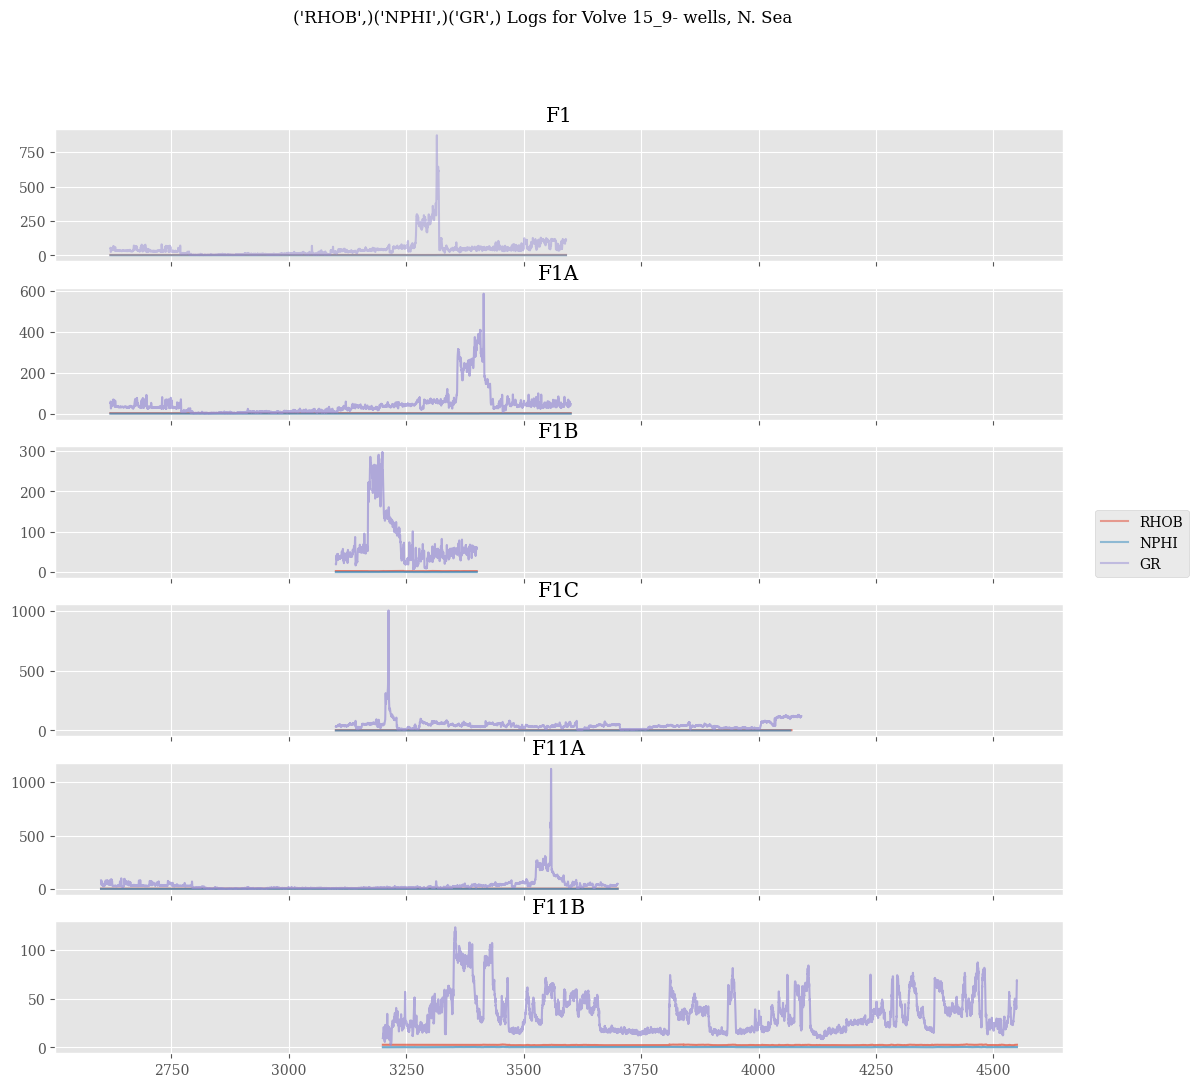

In [7]:

log = ['RHOB', 'NPHI', 'GR']
plt.rcParams['font.family'] = 'serif'
#plt.rcParams["font.monospace"] = ["Courier"]
plt.style.use('ggplot')
lognames = ''
for i in zip(log): lognames += str(i)
fig, ax = plt.subplots(6, figsize=(13,12), sharex=True)
fig.suptitle(lognames+' Logs for Volve 15_9- wells, N. Sea')
ax[0].plot(df_f1clip[log], label=log, alpha=0.5)
ax[0].set_title('F1')
ax[1].plot(df_f1Aclip[log], alpha=0.7)
ax[1].set_title('F1A')
ax[2].plot(df_f1Bclip[log], alpha=0.7)
ax[2].set_title('F1B')
ax[3].plot(df_f1Cclip[log],alpha=0.7)
ax[3].set_title('F1C')
ax[4].plot(df_f11Aclip[log], alpha=0.7)
ax[4].set_title('F11A')
ax[5].plot(df_f11Bclip[log], alpha=0.7)
ax[5].set_title('F11B')
fig.legend(loc='center right')

##### Automation functions that corrects for missing or incomplete data before attempting change point analysis

In [115]:
# Working methods to automate the data grooming and change point detection procedure

def insert_array_to_dataframe(dataframe, array, column_name, index, idx_array):
    """
    Inserts the provided array as a new column in the DataFrame at the specified index.

    Parameters:
        dataframe (pd.DataFrame): The original DataFrame.
        array (array-like): The array to be inserted as a new column.
        column_name (str): The name of the new column to be created.
        index (int): The index where the new column should be inserted.

    Returns:
        pd.DataFrame: The modified DataFrame with the new column inserted.
    """

    # First, convert the array to a pandas Series with appropriate index
    series = pd.Series(array, index=idx_array)

    # Check if the index is within the valid range of the DataFrame
    #if index < 0 or index > len(dataframe.columns):
    #    raise IndexError("Index is out of range.")

    # Split the DataFrame into two parts at the specified index
    left_part = dataframe.iloc[:, :index]
    right_part = dataframe.iloc[:, index:]

    # Insert the new column into the DataFrame
    dataframe = pd.concat([left_part, series.rename(column_name), right_part], axis=1)

    return dataframe

# # Example usage:
# # Create a sample DataFrame
# data = {
#     'A': [1, 2, 3, 4, 5],
#     'B': [10, 20, 30, 40, 50],
#     'C': [100, 200, 300, 400, 500]
# }
# df = pd.DataFrame(data)

# # Example array and column name
# array_to_insert = [1000, 2000, 3000, 4000, 5000]
# column_name_to_insert = 'D'
# index_to_insert = 2

# # Insert the array into the DataFrame at the specified index with the specified column name
# df = insert_array_to_dataframe(df, array_to_insert, column_name_to_insert, index_to_insert)

#print(df)

    '''
    This is a helper function will groom the ends (by holding values) and remove NaN's of an
     incomplete dataset and perform a Bayesian changepoint search.

     results of the search will be added to another row of the dataframe.

     Really should be building a well 'object' that holds this data along with the
     trends and correlation to other wells, but for now it is a dataframe... added to cp_Comparitor.py

    '''


def df_add_CP_Prob(df, start, stop, log_dict=[], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=1000, **kwargs):
    ''' Adds a probability curve for change points to a dataFrame
    
    Parameters:
        df (pandas.Dataframe) : input dataFrame with a dataset mentioned in the log_dictionary 
        log_dict (dict) :  Log dictionary
        label (str)  : Prefix for probability curve that will be appended to the dataFrame
        
        **passthrough argument for replace_nans function**
        nan_method (str) : choices ('global_average', 'local_average', 'linear_interpolation') 
        window_size (int) : window size for calculating local averages.
    
        segment_length (int) : split for offline Bayesian Change Point detection,
                                unsefult to control the computational cost of this function

    Returns: None, this merely adds a curve to the input dataframe

    '''
    
     #Keyword Args assingment
    _prior = kwargs.get('prior') # choices are "const", "geometric", "neg_binomial"
    _method = kwargs.get('method')  # choices are 'gauss', 'ifm' or 'full_cov'
    _engine = kwargs.get('engine')  # choices are "numpy" or "numba"
    _normalize = kwargs.get('normal')

    #Argument Defaults
    if _method == None:
        _method = "full_cov"
    if _prior == None:
        _prior = "const"
    if _engine == None:
        _engine ="numba"
    #if _normalize == False:
    
    print(str(df))
    #Fill ends of incomplete df, replace NaN's with parameter method, and changepoint search with parameter segment splits
    for log in log_dict:
        print(' finding changepoints in '+log)
        labl = label+log
        #df[log][start:stop] = wtool.fill_out_data_ends(df[log][start:stop].values)

        #df[log][start:stop] = wtool.replace_nans(df[log][start:stop].values, method=nan_method, window_size=window_size)
        
        changepoint_prob = cp_Tools.bayes_offline_split(df[log][start:stop].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)
        
        log_index_array = df[log][start:stop].index
        d = {labl : pd.Series(changepoint_prob, index=log_index_array)}
        dfcp = pd.DataFrame(data=d) 
        df = pd.concat([df, dfcp], axis=1,)
        
    return df
        

In [123]:
''' ! ! ! AUCHTUNG ! ! !  ***** This cell will take a bit of time to compute, *****  

time for coffee break? or just take your eyes off the screen.

it took about 15 min with sequence_length=700 I have them individually commented for convenience
to reduce the compute time, reduce the _segment_length variable as this will lighten the computational load
'''

_log_list_ = ['GR','RHOB','NPHI']
_segment_length = 4000 # the method will split the dataset into equal chunks to compute their probabilities separately, mostly for computational efficiency
_window_size = 100 # when filling missing data with the 'local_average' method, this is the parameter fed into np.convolve to impute the missing vals
_normalize = True


df_f1 = df_add_CP_Prob(df_f1clip, start=_logname_extent_min['f1'], stop=_logname_extent_max['f1'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

#cp_Comp.df_add_CP_Prob(df_f1A, start=_logname_extent_min['f1A'], stop=_logname_extent_max['f1A'], log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)
#cp_nphi =

df_f1A = df_add_CP_Prob(df_f1Aclip, start=_logname_extent_min['f1A'], stop=_logname_extent_max['f1A'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

df_f1B = df_add_CP_Prob(df_f1Bclip, start=_logname_extent_min['f1B'], stop=_logname_extent_max['f1B'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

#df_f1C = df_add_CP_Prob(df_f1C, log_dict=_log_list_nodt, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length)#, normal=True)

#df_f1C = df_add_CP_Prob(df_f1Cclip, start=_logname_extent_min['f1C'], stop=_logname_extent_max['f1C'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=True)

df_f11A = df_add_CP_Prob(df_f11Aclip, start=_logname_extent_min['f11A'], stop=_logname_extent_max['f11A'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

df_f11B = df_add_CP_Prob(df_f11Bclip, start=_logname_extent_min['f11B'], stop=_logname_extent_max['f11B'], log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)

# #df_CP_Prob(df_f1A, log_dict=['GR'], label='CP_Prob_', method='local_average', window_size=_window_size, segment_length=_segment_length)

#### template ##### df_CP_Prob(df, log_dict=[], label='CP_Prob_', method='local_average', window_size=_window_size, segement_length=_segment_length)

# data = np.arange(1,100,1)
# ones = np.ones(50)
# df = pd.DataFrame(data, columns=['data'])
# df.insert(50, 'ones', ones)
# df.plot()



                         NPHI          RHOB              GR
DEPTH                                                      
2620.0999999977  0.2612999997  2.5033000004   51.2662999780
2620.1999999977  0.2775999996  2.4735000007   54.5096999270
2620.2999999977  0.2813999999  2.4374000008   54.8417999925
2620.3999999977  0.2701000003  2.3991000009   52.7658000467
2620.4999999977  0.2582000003  2.3666000007   47.5078001183
...                       ...           ...             ...
3589.5999999969  0.2207000001  2.6035000000  116.5063000734
3589.6999999969  0.2191000001  2.6035000000  113.0423001085
3589.7999999969  0.2179000000  2.6046000000  107.8736001619
3589.8999999969  0.2244999998  2.6053000000  107.1986000211
3589.9999999969  0.2220000001  2.6036000001  109.6029999247

[9700 rows x 3 columns]
 finding changepoints in GR
method- full_cov, prior- const, engine- numba
Segmenting into 4000
/n finding changepoints in RHOB9700 of 9700
method- full_cov, prior- const, engine- numba
Segmenting

##### Tuning cell to establish the best parameters for the changepoint search method, many real datasets require it.

In [114]:
df = df_f1B 
log='RHOB'
#labl='CP_prob_test'
nan_method = 'local_average'
window_size= 100
_method ='full_cov'
_prior = 'const'
_engine = 'numba'
segment_length = 1000
_normalize = True

df[log] = wtool.fill_out_data_ends(df[log].values)

df[log] = wtool.replace_nans(df[log].values, method=nan_method, window_size=window_size)
        
np.where(np.isnan(df[log].values)) # reports data gaps 
cp_prob = cp_Tools.bayes_offline_split(df[log][_logname_extent_min['f1B']:_logname_extent_max['f1B']].values, segment_length=segment_length, method=_method, prior=_prior, engine=_engine, normal=_normalize)
#cp_prob_why = df_add_CP_Prob(df_f1Bclip, start=0, stop=len(df_f1Bclip), log_dict=_log_list_, label='CP_Prob_', nan_method='local_average', window_size=_window_size, segment_length=_segment_length, normal=_normalize)
plt.plot(cp_prob, color='b')
plt.show()
#plt.plot(cp_Comp.normalize_array(df[log],0,0))
plt.plot(df[log])

method- full_cov, prior- const, engine- numba
Segmenting into 1000
/n                         NPHI          RHOB             GR
DEPTH                                                     
3100.0999999973  0.0669000000  2.6294000000  19.3109000104
3100.1999999973  0.0681000000  2.6295000000  18.9309000102
3100.2999999973  0.0690000000  2.6298000000  19.2299999920
3100.3999999973  0.0697000000  2.6300000000  19.3023999981
3100.4999999973  0.0706000000  2.6299000000  20.3277999724
...                       ...           ...            ...
3399.5999999970  0.1861000003  2.4570999999  60.4391999769
3399.6999999970  0.1840000001  2.4595999999  61.8451999584
3399.7999999970  0.1798000001  2.4636999999  61.1386000209
3399.8999999970  0.1780000001  2.4713999998  59.3751000522
3399.9999999970  0.1760000001  2.4808999997  58.3742000296

[3000 rows x 3 columns]
 finding changepoints in RHOB


ValueError: zero-size array to reduction operation minimum which has no identity

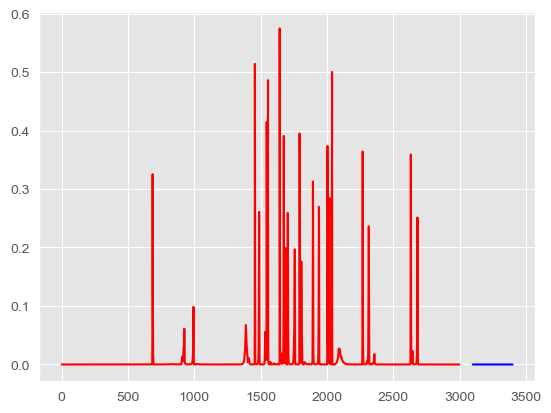

In [119]:
plt.plot(cp_prob, color='r')
plt.plot(cp_prob_why['CP_Prob_RHOB'], color='b')


In [79]:
detOffBay = cp_Tools.sdt_cp.BayesOffline('const', 'full_cov', engine='numba')#, prior_params={'p' : 0.00004})

#data  = np.array([well1['RHO'].to_numpy(), well1['PHI'].to_numpy()])
data1 = cp_Comp.normalize_array(df_f1B['RHOB'][_logname_extent_min['f1B']:_logname_extent_max['f1B']].values,0,0)
data2 = cp_Comp.normalize_array(df_f1B['NPHI'][_logname_extent_min['f1B']:_logname_extent_max['f1B']].values,0,0)
data3 = cp_Comp.normalize_array(df_f1B['GR'][_logname_extent_min['f1B']:_logname_extent_max['f1B']].values,0,0)
datas = np.vstack((data1,data2))
#datas
    #Full output 
#    if _full_output==True:
        #detOffBay = sdt_cp.BayesOffline(_prior, _method, engine=_engine)
prob_comb, q_comb, p_comb, pcp_comb = detOffBay.find_changepoints(datas.T, full_output=True)
prob_phi, q_phi, phi_phi, pcp_phi = detOffBay.find_changepoints(data2.T, full_output=True)
prob_rho, q_rho, phi_rho, pcp_rho = detOffBay.find_changepoints(data1.T, full_output=True)
prob_gr, q_gr, phi_gr, pcp_gr = detOffBay.find_changepoints(data3.T, full_output=True)

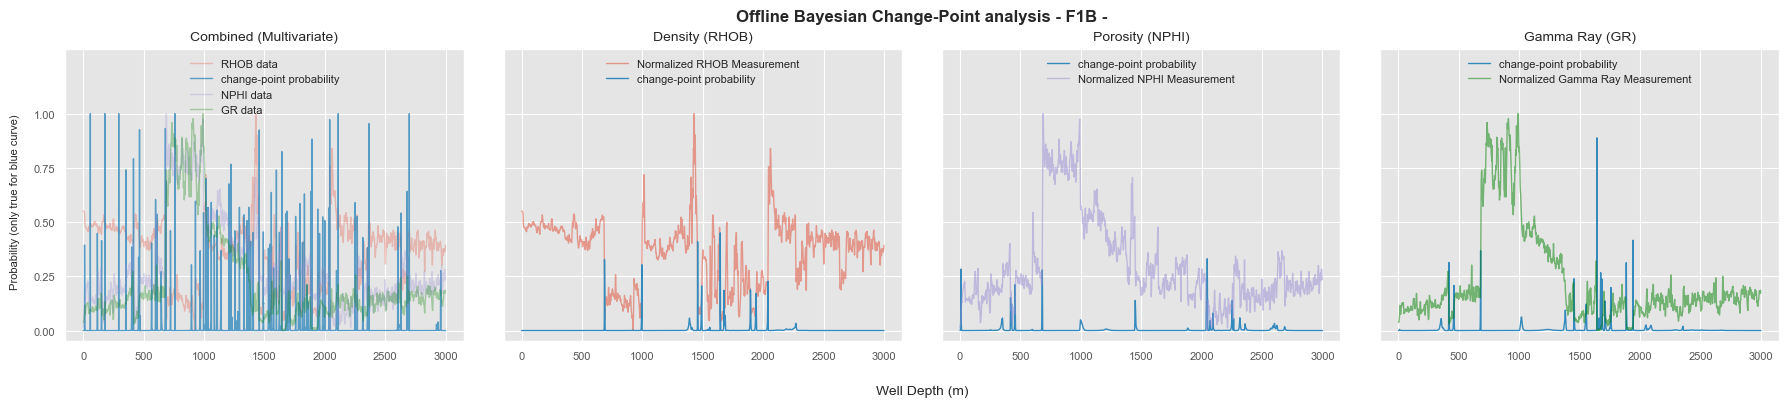

In [78]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,4, figsize=(19,4), sharey=True)

#ax2  = ax.twinx()
ax[0].plot(datas[0,:], label='RHOB data', alpha=0.3, linewidth=1)
ax[0].plot(prob_comb, label='change-point probability', alpha=0.8, linewidth=1)
ax[0].plot(datas[1,:], label='NPHI data',  alpha=0.3, linewidth=1)
#ax[0].plot(datas[2,:], alpha=0.3, label = 'GR data', linewidth=1, color='g')

ax[0].set_title('NPHI + RHOB (Multivariate)', size=10)
ax[1].plot(datas[0,:], alpha=.5, label = 'Normalized RHOB Measurement', linewidth=1)
ax[1].plot(prob_rho, label='change-point probability', linewidth=1)
ax[1].set_title('Density (RHOB)', size=10)

ax[2].plot(datas[1,:], alpha=0, linewidth=1)
ax[2].plot(prob_phi, label='change-point probability', linewidth=1)
ax[2].plot(datas[1,:], alpha=0.5, label = 'Normalized NPHI Measurement', linewidth=1)
ax[2].set_title('Porosity (NPHI)', size=10)

ax[3].plot(datas[2,:], alpha=0, linewidth=1)
ax[3].plot(prob_gr, label='change-point probability', linewidth=1)
ax[3].plot(datas[2,:], alpha=0.5, label = 'Normalized Gamma Ray Measurement', linewidth=1, color='g')
ax[3].set_title('Gamma Ray (GR)', size=10)

#ax[0].plot(prob_comb, 'change-point probability')
##ax2.plot(welldata1[2], label='True Value')
#ax.plot(cp_Comp.normalize_array(welldata1[2],0,0)*0.9)
for i in range(4):
    ax[i].legend(loc='upper center',fontsize=8, frameon=False)
    ax[i].set_ylim(-0.05,1.3)
    ax[i].set_yticks([0,.25,.5,.75,1])
    #ax[i].set_xticks([505,705,910,1224,1326,1462])
#ax[i].set_xticks([1095,893,690,376,270,137])
    ax[i].tick_params(labelsize=8)
fig.suptitle('Offline Bayesian Change-Point analysis - F1B -', fontweight='bold')
#x.legend()

fig.supxlabel('Log Index (t)', size=10)
fig.supylabel('Probability (only true for blue curve)', size=8)
fig.subplots_adjust(
    top=0.881,
    bottom=0.149,
    left=.049,
    right=0.951,
    hspace=0.1,
    wspace=0.1
)
fig.savefig('..//..//reports//figures//f1B_cp_analysis.svg')
#plt.plot(welldata1[3]

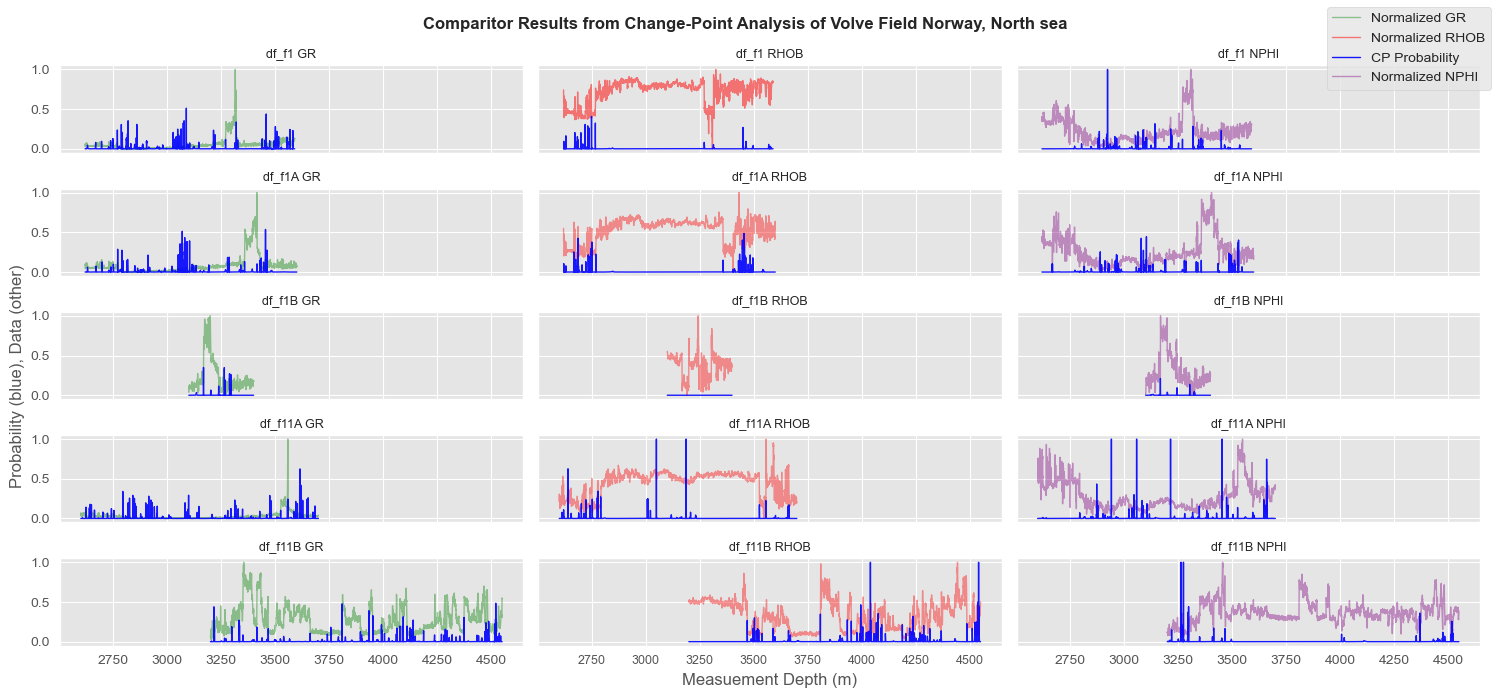

In [125]:
# BUILD NORMALIZED DATA FOR PLOTTING PROBABILITY RESULTS FOR THE COMPARITORS


plt.style.use('ggplot')
fig, ax = plt.subplots(5,3, sharex=True, sharey=True,figsize=(15,7), layout='tight')

_log_list_ = ['RHOB','NPHI','GR']

_prob_list_ = ['CP_Prob_RHOB','CP_Prob_NPHI','CP_Prob_GR']

#_wellnames_ = ['well1','well2', 'well3', 'well4', 'well5', 'well6']
#_well_df_ = {'well1': well1, 'well2': well2, 'well3': well3, 'well4': well4, 'well5': well5, 'well6' : well6}

_wellnames_ = ['df_f1','df_f1A', 'df_f1B', 'df_f11A', 'df_f11B']
_well_df_ = {'df_f1' : df_f1, 'df_f1A' : df_f1A, 'df_f1B' : df_f1B, 'df_f11A' : df_f11A, 'df_f11B' : df_f11B}
#ax[0,0].set_xticks([0,800,1600])
label_size = 9
#plt.rcParams['xtick.labelsize'] = label_size
ax[4,1].tick_params(labelsize=9)
ax[4,1].set_xlabel('Measuement Depth (m)', size=12)
ax[2,0].set_ylabel('Probability (blue), Data (other)         ')
#tick_params(labelsize=9)
for well in _wellnames_:
    for _log_choice in _log_list_:
        #print(cp_Comp.normalize_array(_well_df_[well][_log_choice],0,0))
        globals()[well+'_'+_log_choice+'_norm'] = cp_Comp.normalize_array(_well_df_[well][_log_choice],0,0)
       
for i, well in zip(range(len(_wellnames_)), _wellnames_):
    for j, prob_ in zip(range(len(_log_list_)), _prob_list_):
        #ax[i,j].legend(loc='center right',fontsize=7)
        if j==0:
            
            ax[i,1].set_title(well+' '+_log_list_[j], fontsize=9)
            if i == 0:
                ax[i,1].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, label='Normalized RHOB', alpha=0.5, color='r')
                ax[i,1].plot(_well_df_[well][prob_], linewidth=1, label='CP Probability', color='b', alpha=0.9)
            else:
                ax[i,1].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, alpha=0.4,color='r')

                ax[i,1].plot(_well_df_[well][prob_], linewidth=1, color='b', alpha=0.9)
        elif j==1:
            if i == 1:
                ax[i,2].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, label='Normalized NPHI', alpha=0.4,color='purple')
            else:
                ax[i,2].plot(globals()[well+'_'+_log_list_[j]+'_norm'], linewidth=1, alpha=0.4,color='purple')
            ax[i,2].set_title(well+' '+_log_list_[j], fontsize=9)
            ax[i,2].plot(_well_df_[well][prob_], linewidth=1, color='b', alpha=0.9)
        elif j == 2:
            #ax[i,0].plot(globals()[well+'_NPHI_norm'], linewidth=1, alpha=0.3, color='purple')
            #ax[i,0].plot(globals()[well+'_RHOB_norm'], linewidth=1, alpha=0.3, color='r')
            if i == 0:
                ax[i,0].plot(globals()[well+'_GR_norm'], linewidth=1, alpha=0.4, color='g', label='Normalized GR')
            else:
                ax[i,0].plot(globals()[well+'_GR_norm'], linewidth=1, alpha=0.4, color='g')
            ax[i,0].set_title(well+' GR', fontsize=9)
            ax[i,0].plot(_well_df_[well][prob_], linewidth=1, color='b', alpha=0.9)
fig.legend(fontsize=10, frameon=True)
fig.suptitle('Comparitor Results from Change-Point Analysis of Volve Field Norway, North sea', fontweight='bold')
fig.savefig('..//..//reports//figures//volve_cp_analysis.svg')

##### Segment lengths for the changepoint detection have sunstantial influence on the posterior probability curve

###### Where this effect is less pronounced in datasets with more variance, there are some sequences with obvious shifts that are not recognized by the algorithm unless the prior data sufficiently encapsulates the data variance from within multiple changes within the data. This limitation demands that to some extent, tuning is required to best characterize the probabilties found with this method so as to avoid false positives or build additional confidence factors

###### In a practical sense, this tuning could be derived stochastically or by way of weighting change points found in this method with other discrete change point methods, such as PELT, or by evaluating the likeliness with a focused single change point method.  But, these will further add to the computational cost for analysis.



##### There is also a question of noise reduction, for example by computing the rolling average of a dataset.
###### a rolling average is often used to deconvolute the data so that changepoints are less obscured ba them, but it seems that the Offline Bayesian search function is quite robustly finding changepoints without this step. 
###### Arguably, it even does a better job with RAW data, this simple comparison is meant to demonstrate that.

In [16]:
''' This Shows that performing the change point analysis on a log and a rolling average of the log produce comparable results, if not slightly muted for the Avg.'''
#data_f1A = wtool.compute_all_rolling_avg(df_f1A, window=30, periods=3)

_segment_length = 1400

data_f1A = df_add_CP_Prob(data_f1A, start=_logname_extent_min['f1A'], stop=_logname_extent_max['f1A'], log_dict=['GR', 'Roll_Avg_GR' ], label='CP_Prob_', nan_method='local_average', window_size=200, segment_length=_segment_length)

fig, ax = plt.subplots(1, figsize=(10,4))
ax.set_xlim((2600,3700))
#ax[0].plot(data_f1A['CP_Prob_Roll_Avg_GR']-data_f1A['CP_Prob_GR'])


ax.plot(data_f1A['GR']/data_f1A['GR'].max()+1.8, label='Data Raw')
ax.plot(data_f1A['CP_Prob_GR']+1.5, label='Prob RAW GR', color='green', alpha=0.7)

ax.plot(data_f1A['Roll_Avg_GR']/data_f1A['Roll_Avg_GR'].max(), label='Data Roll Avg')
ax.plot(data_f1A['CP_Prob_Roll_Avg_GR']-0.4, label='Prob GR rolling avg', alpha=0.7, color='red')

fig.suptitle('Comparing Offline Bayesian CP detection with raw log data or rolling average of that data, Segment length 900')
fig.legend(loc=('center right'));


NameError: name 'data_f1A' is not defined

,NPHI,RHOB,GR,CP_Prob_GR,CP_Prob_RHOB,CP_Prob_NPHI
DEPTH,,,,,,
2620.0999999977,0.2612999997,2.5033000004,51.2662999780,0.0000000000,0.0000000000,0.0000000000
2620.1999999977,0.2775999996,2.4735000007,54.5096999270,0.0000001443,0.0000010787,0.0000257110
2620.2999999977,0.2813999999,2.4374000008,54.8417999925,0.0000001363,0.0000024372,0.0000226913
2620.3999999977,0.2701000003,2.3991000009,52.7658000467,0.0000001309,0.0000041705,0.0000187826
2620.4999999977,0.2582000003,2.3666000007,47.5078001183,0.0000002812,0.0000059970,0.0000212046


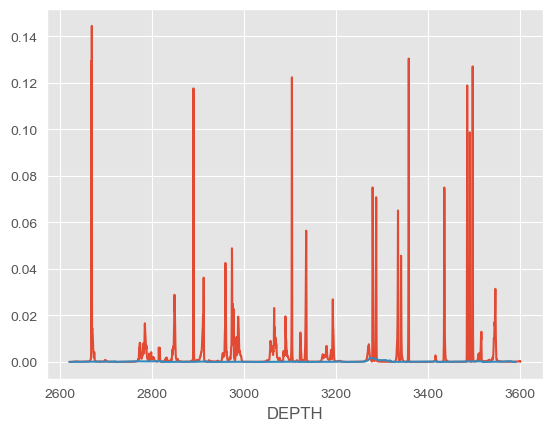

In [101]:
df_f1A['CP_Prob_NPHI'].plot()
df_f1['CP_Prob_RHOB'].plot()

df_f1.head()

##### Establishing changepoint TREND statistics for all input wells.
###### These will be used for geometric comparison with the stats. of change points of a compariTEE(unknown or investigated well) to compariTOR_s(known or prior wells). 

In [126]:
_log_ = 'GR'
_prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']
#_wellnames_ = ['f1B']
_wellnames_ = ['f1','f1A', 'f1B', 'f11A', 'f11B'] #omitted F1C
_well_df_ = {'f1': df_f1, 'f1A': df_f1A, 'f1B': df_f1B,'f11A': df_f11A, 'f11B' : df_f11B} #omitted f1C

peak_height= 0.01 #Probability threshold to qualify as a distinct changepoint

for well in _wellnames_:
    for _log_choice, _prob_choice in zip(_log_list_nodt, _prob_list_nodt):

        globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                    _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

        print(well+ '_'+ _log_choice + ' complete')


#globals()[prefix + str(var_num) + suffix] =    

69 Change points: [1513 1523 1833 2265 2270 2276 2288 2605 2656 2852 2976 3008 3024 3035
 3049 3164 3253 3323 3349 3351 3373 3392 3407 3409 3455 3468 3549 3585
 4066 4154 4335 4364 4367 4418 4425 4440 4456 4490 4683 4748 4801 4822
 4843 5048 5051 5141 5228 5257 5881 5893 5957 6007 6321 6504 6993 7021
 7227 7252 7263 7358 7430 7445 8301 8450 8464 8621 8707 9147 9156]
f1_NPHI complete
44 Change points: [  12   30   84  108  511  517  522  546  556  572  592  642  659  672
  802  830  883  891 1000 1047 1119 1176 1295 1315 1473 2257 2263 6512
 6939 6969 8304 8423 8448 8465 8472 8751 8772 8779 9496 9520 9552 9575
 9592 9616]
f1_RHOB complete
145 Change points: [  85  109  127  488  761 1085 1181 1285 1492 1572 1578 1582 1589 1598
 1602 1608 1610 1676 1721 1729 1733 1894 1906 1913 1925 1953 1962 1972
 1977 1980 1988 1995 2088 2097 2110 2113 2115 2284 2290 2297 2367 2392
 2408 2506 2571 2654 2661 2667 2673 2842 2847 2946 2953 2961 2963 2969
 3307 3313 3315 3319 3321 3327 3351 3354 3438 3440 

In [ ]:
#plt.plot(df_f1A['CP_Prob_GR'][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy())
np.shape(f11A_GR_CPstats)


(345, 5)

##### Finding breakpoints and trends for Volve input, ONLY UNIVARIATE LOGS for this example:
###### Changepoints are identified by SciPy find_peaks of a offline bayesian changepoint probability curve. Using sdt-python (implementation of Fearnhead 2006) 
###### Trend values are the mean for the data sections between breakpoints. (will soon include a more complete comparitor vector [CP, AvgL, AvgR, \sigma L, \sigma R, \alpha \beta \sigma L, \alpha \beta \sigma R])


##### This section runs a very permissible cosine similarity inference, so there is a lot of noise in the result.

Finding a more decerning algorithm is a topic of research on it's own but for this example it illustrates the point.
 

In [127]:
# Identified tops from the well 15-9 -F11A to compare against the output

f11A_FM = {0:'Norland GP FM', 1:'Ty FM', 2:'Ekofisk FM', 3:'Hod FM', 4:'Draupne FM', 5:'Heather FM', 6:'Heather FM (Sand)', 7:'Hugin FM', 8:'Sleipner FM'}
f11A_color = {0:'r', 1:'g', 2:'purple', 3:'orange', 4:'yellow', 5:'grey', 6:'black', 7:'pink', 8:'blue'}
f11A_tops = np.array([26000-26000, 26240-26000, 27945-26000, 31180-26000, 35258-26000, 35749-26000, 35852-26000, 35946-26000, 37020-26000])

vectors = []

In [19]:
def prob_cpCorr(cpComparitee, cpComparitor, **kwargs):
    
    '''Correlation engine for changepoint associations:
    takes in two matrix (m  x n) of changepoints/trends. One compariTEE who is compared to the compariTOR.
    
    Relative changepoint (vector[0]) and corresponding trend values (vector[1:]) 
    
    
    Uses a kwarg to choose the geometric comparitor operation:
    
    operator= 
    'cosine'
    'euclidean'
    'theta'
    'triangle'
    'sector'
    'mag'


    Builds output of change points that correspond to all remaining changepoints after the matching input vector. 
    '''

    #for key, value in kwargs.items():
        #print(f"{key}: {value}")

    tee = cpComparitee
    tor = cpComparitor
    
    opFunc_dict = {'cosine':cp_Comp.Cosine}#, 'euclidean': Euclidean, 'theta': Theta, 'triangle': Triangle, 'sector': Sector, 'magnitude': Magnitude_Difference} 
    _operator = kwargs.get('operator')
    
    _threshold = kwargs.get('thresh')

    _df = kwargs.get('df')
    _log = kwargs.get('log')



    operator = opFunc_dict[_operator]

    QumeProb = np.array(([0],[0]))
    #k = 1
    '''    
    cos_thresh = 0.999999 # match is 1.0 (very tight threshhold, all reasonalble values are very close to 1.0)
    euclidean_thresh = 0.1 # match is near zero
    theta_thresh = 0.1745 # match is .1745
    triangle_thresh = 0.2 # match is near zero
    sector_thresh = 0.1 # match is near zero
    '''
    
    for i in range(1,len(tee)):
        for j in range(1,len(tor)):
            idx = int(tor[j][0])
            teeTee = np.concatenate((tee[i-1][1:],tee[i][1:]))
            torTor = np.concatenate((tor[j-1][1:],tor[j][1:]))
            #print('iter')
            #print(tor[j][1],tor[j][2])
            #print(tee[i][1],tee[i][2])
            #if tor[j][1] == tee[i][1] and tor[j][2] == tee[i][2]:
            if operator(torTor, teeTee) >= _threshold:
                jump = int(tee[i][0])
                #print(type(jump)) 
                print('*MATCH at ' + _log + ' Tor depth '+ str(idx)+ ' to Tee depth '+str(jump)+ ' with ' + _operator + ' value ' + str(operator(torTor, teeTee)))
                probAdd = _df[_log][jump:].to_numpy()
                #print(tor[i][1],tor[i][2])
                #print(tee[j][1],tee[j][2])
                QumeProb = combine_vector_and_matrix(probAdd, QumeProb, jump)
                print('adding Tor probabilites from '+str(jump))     
    #unique, counts = np.unique(CumulativeProb, return_counts=True)
    
    V = QumeProb.sum(axis=0)
    
    return V #, QumeProb

In [144]:
# _log_ = 'GR'
# _prob_ = 'CP_Prob_GR'

_log_list_nodt = ['NPHI','RHOB','GR']
_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']

_wellnames_ = ['f1','f1A', 'f1B', 'f11B']
_well_df_ = {'f1': df_f1, 'f1A': df_f1A, 'f1B': df_f1B, 'f11A': df_f11A, 'f11B' : df_f11B} # omitted f1C

#peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

operator = 'cosine'
thresh = {'CP_Prob_NPHI': 0.9995 ,'CP_Prob_RHOB': 0.99997,'CP_Prob_GR': 0.999}#0.9999


comparitee = 'f11A'

Tor = []

for well in _wellnames_:
    for _prob_, _log_ in zip(_prob_list_nodt,_log_list_nodt):
        print(_prob_,_log_)
        Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
        Tor = globals()[well+'_'+_log_+'_CPstats']
    
        globals()[well+'_'+comparitee+'_'+_log_+'_prob'] = cp_Comp.prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh[_prob_], df=_well_df_[well], log=_prob_)

    #f1_11A_GR_prob = prob_cpCorr(f11A_GRmu, f1_GRmu, operator=operator, thresh = thresh, df=df_f1clip, log='CP_Prob_GR')

CP_Prob_NPHI NPHI
*MATCH at CP_Prob_NPHI Tor depth 3373 to Tee depth 2149 with cosine value 0.9995837659634393
adding Tor probabilites to Tee cumulative matix, from 2149
*MATCH at CP_Prob_NPHI Tor depth 4364 to Tee depth 2149 with cosine value 0.9995462293845472
adding Tor probabilites to Tee cumulative matix, from 2149
*MATCH at CP_Prob_NPHI Tor depth 2270 to Tee depth 2151 with cosine value 0.9997084649237121
adding Tor probabilites to Tee cumulative matix, from 2151
*MATCH at CP_Prob_NPHI Tor depth 2276 to Tee depth 2151 with cosine value 0.9996964141526445
adding Tor probabilites to Tee cumulative matix, from 2151
*MATCH at CP_Prob_NPHI Tor depth 3351 to Tee depth 2151 with cosine value 0.9995841975339971
adding Tor probabilites to Tee cumulative matix, from 2151
*MATCH at CP_Prob_NPHI Tor depth 5051 to Tee depth 2163 with cosine value 0.9997843108502834
adding Tor probabilites to Tee cumulative matix, from 2163
*MATCH at CP_Prob_NPHI Tor depth 8301 to Tee depth 3414 with cosine va

In [ ]:
np.shape(f1_f11A_RHOB_prob)

(1,)

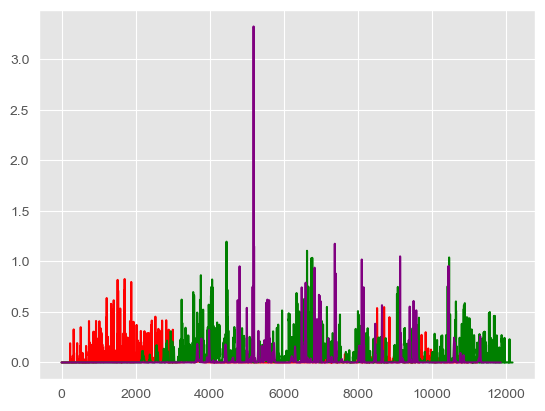

In [145]:
plt.plot(f1_f11A_RHOB_prob, color='r')
plt.plot(f1_f11A_GR_prob, color='g')
plt.plot(f1_f11A_NPHI_prob, color='purple')

In [147]:
''' Derived probability curves from the comparitors statistics are now combined, with simple matrix stacking, into a
total probability curve as wells as curves that are composed of the individual log components '''

f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob, f1A_f11A_NPHI_prob,  f11B_f11A_NPHI_prob, f1B_f11A_NPHI_prob,
                                                      f1_f11A_RHOB_prob, f1A_f11A_RHOB_prob,  f11B_f11A_RHOB_prob, f1B_f11A_RHOB_prob,
                                                      f1_f11A_GR_prob, f1A_f11A_GR_prob, f11B_f11A_GR_prob, f1B_f11A_GR_prob, 
                                                     #f1_f11A_PEF_prob, f1A_f11A_PEF_prob, f11B_f11A_PEF_prob, f1B_f11A_PEF_prob,
                                                     )

f11A_probmatrixNPHI = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob,
                                                        f1A_f11A_NPHI_prob,
                                                         f1B_f11A_NPHI_prob,
                                                         #f1C_f11A_NPHI_prob, 
                                                         f11B_f11A_NPHI_prob)

f11A_probmatrixRHOB = cp_Comp.combine_vectors_to_matrix_(f1_f11A_RHOB_prob,
                                                         f1A_f11A_RHOB_prob, 
                                                         f1B_f11A_RHOB_prob,
                                                         #f1C_f11A_RHOB_prob, 
                                                         f11B_f11A_RHOB_prob)

f11A_probmatrixGR = cp_Comp.combine_vectors_to_matrix_(f1_f11A_GR_prob,
                                                       f1A_f11A_GR_prob,
                                                       f1B_f11A_GR_prob, 
                                                       #f1C_f11A_GR_prob, 
                                                       f11B_f11A_GR_prob
                                                       )


# f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(np.sum(f11A_probmatrixGR, axis=1),
#                                                      np.sum(f11A_probmatrixNPHI, axis=1),
#                                                      np.sum(f11A_probmatrixRHOB, axis=1)
#                                                     )   

# f11A_probmatrixPEF = cp_Comp.combine_vectors_to_matrix_(f1_f11A_PEF_prob, # PEF produces no results :(
#                                                          f1A_f11A_PEF_prob, 
#                                                          f1C_f11A_PEF_prob, 
#                                                          f11B_f11A_PEF_prob) #f1B_11A_PEFcorr,

f11A_all_prob = cp_Comp.combine_vectors_to_matrix_(df_f11A['CP_Prob_GR'],
                                                    df_f11A['CP_Prob_NPHI'],
                                                    #df_f11A['CP_Prob_PEF'],
                                                    df_f11A['CP_Prob_RHOB']
                                                    )




rows  16626 columns 12
rows  16626 columns 4
rows  15261 columns 4
rows  15909 columns 4
rows  11000 columns 3


In [148]:
# np.sum(f11A_probmatrixGR, axis=1)


In [149]:
# this the clipped Gamma Ray log from the Comparitee vector

# f11A_gr = (cp_Comp.normalize_array(df_f11Aclip['GR'].to_numpy(), 0, 0))+26000
# f11A_nphi = (cp_Comp.normalize_array(df_f11Aclip['NPHI'].to_numpy(), 0, 0))+26000
# #f11A_pef = cp_Comp.normalize_array(df_f11A['PEF'][2600:].to_numpy(), 0, 0)
# f11A_rhob = (cp_Comp.normalize_array(df_f11Aclip['RHOB'].to_numpy(), 0, 0))+26000

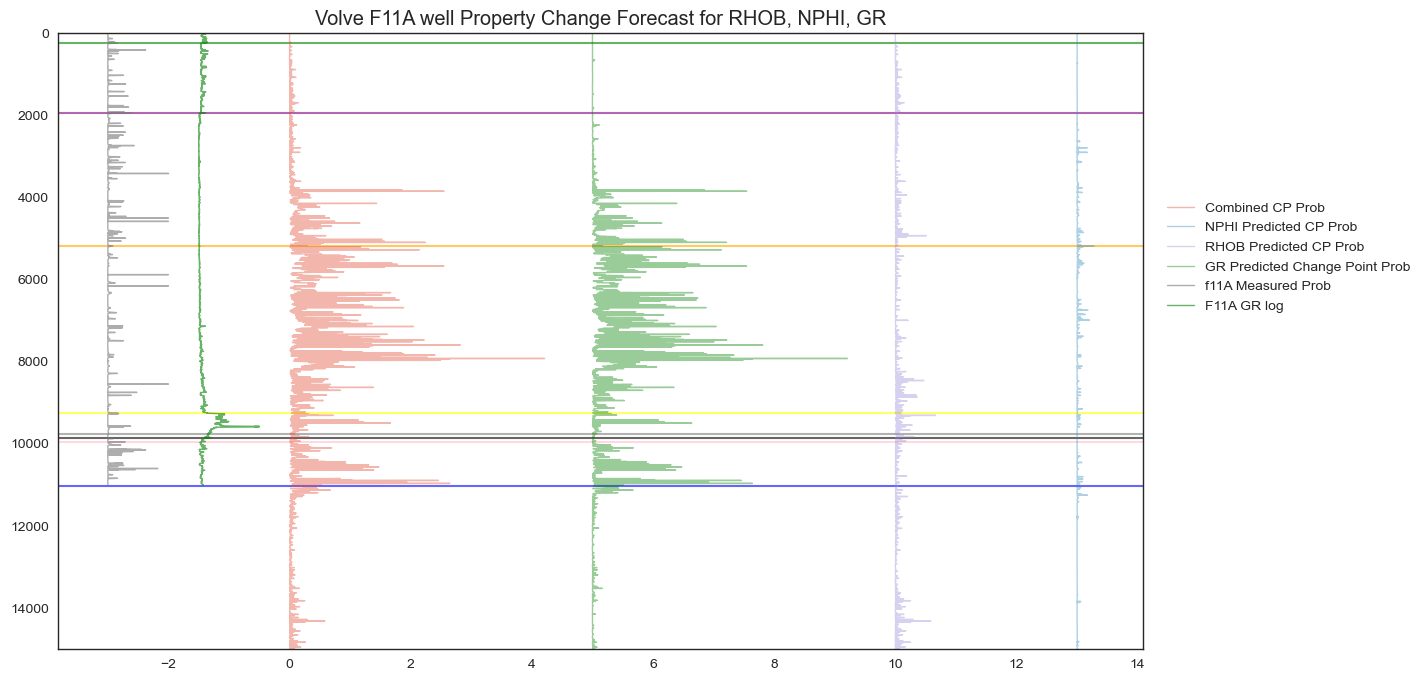

In [157]:
import matplotlib as mpl
#cmap = mpl.colormaps['']
fig, ax = plt.subplots(1, figsize=(14,8))
#plt.figure(figsize=(10,15))
ax.set_ylim((15000,0))
#ax.set_xlim(25)
f11A_top10 = f11A_tops #25400
k=0
for i in f11A_top10:
    ax.axhline(i, alpha=0.6, color=f11A_color[k])#, label=f11A_FM[k])
    #print(k)
    k=k+1
ax.plot(np.sum(f11A_probmatrix, axis=1)/len(f11A_probmatrix[0]), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.4, label='Combined CP Prob' )
ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)/len(f11A_probmatrix[0])+13, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.4, label = 'NPHI Predicted CP Prob' )
ax.plot(np.sum(f11A_probmatrixRHOB, axis=1)/len(f11A_probmatrix[0])+10, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.4, label = 'RHOB Predicted CP Prob' )
#ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='PEF Predicted CP Prob')
ax.plot(np.sum(f11A_probmatrixGR, axis=1)/len(f11A_probmatrix[0])+5, np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.4, label = 'GR Predicted Change Point Prob', color='green' )
#ax.plot(f11A_gr*3, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_pef*3+ +7, np.arange(len(f11A_pef)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_nphi*3, np.arange(len(f11A_nphi)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_rhob*3, np.arange(len(f11A_rhob)) , linewidth=1, alpha=.6, label='GR f11A')
ax.plot(np.sum(f11A_all_prob, axis=1)-3, np.arange(len(f11A_all_prob)), linewidth=1, alpha=0.6, label='f11A Measured Prob')
f11A_GR = (cp_Comp.normalize_array(wtool.replace_nans(df_f11A['GR'].to_numpy(), method='global_average'), 0.1 ,0.1))
f11A_y = np.arange(len(f11A_GR))
ax.plot(f11A_GR-1.5, f11A_y, linewidth=1, color='g', alpha=0.6, label='F11A GR log')
maxx = len(df_f11A)

plt.title('Volve F11A well Property Change Forecast for RHOB, NPHI, GR')
#f11A_top10
#cmap = plt.colormaps('turbo')


fig.legend(loc='center right', frameon=False, bbox_to_anchor=(1.1,.6))

##### So, there are some issues with this result... mostly that they are ambiguous.

###### first and most obvious are that none of the formation tops (horizontal lines) have any obvious relation to the probaility mass of ony of the curves, frankly there is also a lot of noise. In the signal. 

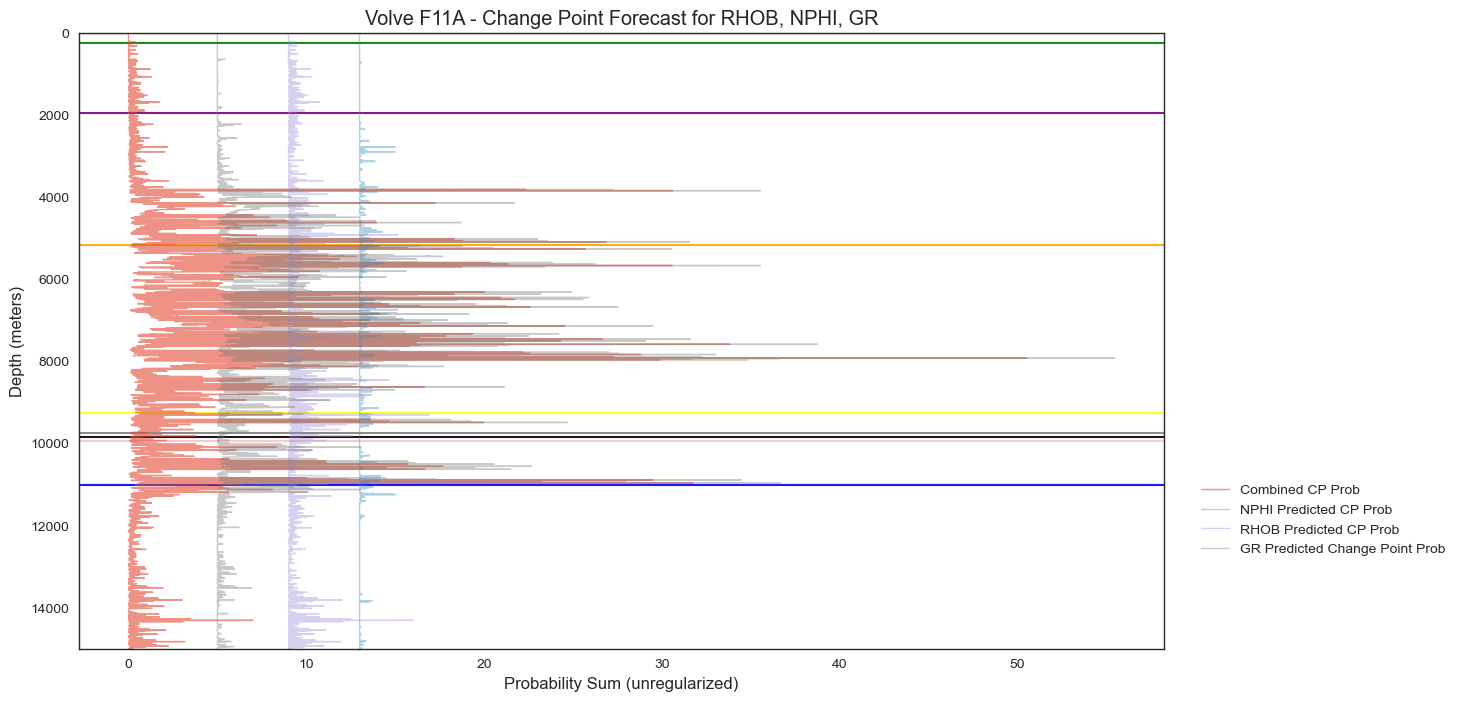

In [160]:

#cmap = mpl.colormaps['']
fig, ax = plt.subplots(1, figsize=(14,8))
#plt.figure(figsize=(10,15))
ax.set_ylim((15000,0))
#ax.set_xlim(25)
f11A_top10 = f11A_tops #25400
k=0
for i in f11A_top10:
    ax.axhline(i, alpha=0.9, color=f11A_color[k], linewidth=1.5)
    #print(k)
    k=k+1
ax.plot(np.sum(f11A_probmatrix, axis=1), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.6, label='Combined CP Prob' )
ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)+13, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.4, label = 'NPHI Predicted CP Prob' )
ax.plot(np.sum(f11A_probmatrixRHOB, axis=1)+9, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.4, label = 'RHOB Predicted CP Prob' )
#ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='PEF Predicted CP Prob')
ax.plot(np.sum(f11A_probmatrixGR, axis=1)+5, np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.4, label = 'GR Predicted Change Point Prob' )
#ax.plot(f11A_gr*3, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_pef*3+ +7, np.arange(len(f11A_pef)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_nphi*3, np.arange(len(f11A_nphi)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(f11A_rhob*3, np.arange(len(f11A_rhob)) , linewidth=1, alpha=.6, label='GR f11A')
#ax.plot(np.sum(f11A_all_prob, axis=1)-3, np.arange(len(f11A_all_prob)), linewidth=1, alpha=0.7, label='f11A Combined Prob')
#f11A_GR = (cp_Comp.normalize_array(wtool.replace_nans(df_f11A['GR'].to_numpy(), method='global_average'), 0.1 ,0.1))
#f11A_y = np.arange(len(f11A_GR))
#ax.plot(f11A_GR-1.5, f11A_y, linewidth=1, label='F11A GR log')
#maxx = len(df_f11A)

plt.title('Volve F11A - Change Point Forecast for RHOB, NPHI, GR')
#f11A_top10
#cmap = plt.colormaps('turbo')
ax.set_xlabel('Probability Sum (unregularized)')
ax.set_ylabel('Depth (meters)')

fig.legend(loc='center right', frameon=False, bbox_to_anchor=(.11, 0.22, 1., .102),)
#fig.savefig('Small100dp_changepoint_high_thresh.svg')

In [181]:
f11A_RHOB_CPstats[:][-1]

array([ 1.09870000e+04,  2.23530769e+00,  3.58167598e-03, -7.08791224e-04,
        2.23956044e+00])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f11B_GR complete
1
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
rows  1 columns 12
rows  1 columns 4
rows  1 columns 4
rows  1 columns 4
rows  11000 columns 3
1
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 9257]
f1A_NPHI complete
34 Change points: [  11  107  477  493  565  580  666  691  855  862 1030 1143 1200 1254
 1282 1312 1496 7383 8097 8149 8182 8211 8263 8279 8292 8350 8374 8400
 8434 8547 8642 8709 8716 8760]
f1A_RHOB complete
54 Change points: [ 109  508  779 1194 1309 1507 1701 1748 1750 1754 1935 1939 1967 2299
 2302 2909 2987 3686 4022 4309 4361 4395 4405 4412 4496 4505 4509 4511
 4533 4571 4587 4603 4610 4697 4717 4730 4835 4952 5022 5132 5724 6594
 6669 7201 7381 7957 8092 8153 8259 8349 8361 8369 8374 8423]
f1A_GR complete
3 Change points: [ 681 1450 2038]
f1B_NPHI complete
0 Change points: []
f1B_RHOB complete
7 Change points: [ 680 1018 1381 1643 1684 1884 1943]
f1B_GR complete
35 Ch

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f11B_GR complete
440
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4580 to Tee depth 239 with cosine value 0.9987287782251418
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4568 to Tee depth 396 with cosine value 0.9983853445750778
adding Tor probabilites to Tee cumulative matix, from 396
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4730 to Tee depth 239 with cosine value 0.9975791822928743
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4717 to Tee depth 396 with cosine value 0.9975441465422682
adding Tor probabilites to Tee cumulative matix, from 396
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 4611 to Tee depth 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f11B_GR complete
550
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4580 to Tee depth 239 with cosine value 0.9987287782251418
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4568 to Tee depth 396 with cosine value 0.9983853445750778
adding Tor probabilites to Tee cumulative matix, from 396
*MATCH at CP_Prob_GR Tor depth 4580 to Tee depth 436 with cosine value 0.9985512274463328
adding Tor probabilites to Tee cumulative matix, from 436
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4730 to Tee depth 239 with cosine value 0.9975791822928743
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4717 to Tee depth 396 with cosine value 0.9975441465422682
adding Tor probabilites to Tee cumulative matix

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f11B_GR complete
770
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 522 to Tee depth 407 with cosine value 0.9999809770331478
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1176 to Tee depth 407 with cosine value 0.9999706173419576
adding Tor probabilites to Tee cumulative matix, from 407
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4580 to Tee depth 239 with cosine value 0.9987287782251418
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4568 to Tee depth 396 with cosine value 0.9983853445750778
adding Tor probabilites to Tee cumulative matix, from 396
*MATCH at CP_Prob_GR Tor depth 4580 to Tee depth 436 with cosine value 0.9985512274463328
adding Tor probabilites to Tee cumulative matix, from 436
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_GR Tor depth 10803 to Tee depth 396 with cosine value 0.9977440297372875
adding Tor probabilites to Tee cumulative matix, from 396
*MATCH at CP_Prob_GR Tor depth 10940 to Tee depth 492 with cosine value 0.9995714059670266
adding Tor probabilites to Tee cumulative matix, from 492
*MATCH at CP_Prob_GR Tor depth 11737 to Tee depth 492 with cosine value 0.9985626572018488
adding Tor probabilites to Tee cumulative matix, from 492
rows  13992 columns 12
rows  1 columns 4
rows  13907 columns 4
rows  13992 columns 4
rows  11000 columns 3
880
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  1 columns 4
rows  13907 columns 4
rows  13992 columns 4
rows  11000 columns 3
990
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_RHOB Tor depth 4698 to Tee depth 902 with cosine value 0.999979354688205
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 7956 to Tee depth 902 with cosine value 0.9999871425655253
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 8339 to Tee depth 902 with cosine value 0.9999846318888717
adding Tor probabilites to Tee cumulative matix, from 902
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 10803 to Tee depth 396 with cosine value 0.9977440297372875
adding Tor probabilites to Tee cumulative matix, from 396
*MATCH at CP_Prob_GR Tor depth 10940 to Tee depth 492 with cosine value 0.9995714059670266
adding Tor probabilites to Tee cumulative matix, from 492
*MATCH at CP_Prob_GR Tor depth 11737 to Tee depth 492 with cosine value 0.9985626572018488
adding Tor probabilites to Tee cumulative matix, from 492
*MATCH at CP_Prob_GR Tor depth 11053 to Tee depth 633 with cosine value 0.9984699854830951

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  1 columns 4
rows  14402 columns 4
rows  14133 columns 4
rows  11000 columns 3
1210
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_GR Tor depth 4717 to Tee depth 396 with cosine value 0.9975441465422682
adding Tor probabilites to Tee cumulative matix, from 396
*MATCH at CP_Prob_GR Tor depth 4835 to Tee depth 492 with cosine value 0.9975723324843204
adding Tor probabilites to Tee cumulative matix, from 492
*MATCH at CP_Prob_GR Tor depth 1967 to Tee depth 633 with cosine value 0.9980617955014924
adding Tor probabilites to Tee cumulative matix, from 633
*MATCH at CP_Prob_GR Tor depth 1194 to Tee depth 1023 with cosine value 0.997987799335981
adding Tor probabilites to Tee cumulative matix, from 1023
*MATCH at CP_Prob_GR Tor depth 5132 to Tee depth 1023 with cosine value 0.9977922836354435
adding Tor probabilites to Tee cumulative matix, from 1023
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 4611 to Tee depth 204 with cosine value 0.999978048880737
adding Tor probabilites to Tee cumulative matix, from 204
*MATCH at CP_Prob_RHOB

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_GR Tor depth 8730 to Tee depth 1234 with cosine value 0.9981603936465376
adding Tor probabilites to Tee cumulative matix, from 1234
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 407 with cosine value 0.9999898143259657
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1282 to Tee depth 407 with cosine value 0.9999841433342672
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 8716 to Tee depth 902 with cosine value 0.9999738330905728
adding Tor probabilites to Tee cumulative matix, from 902
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4730 to Tee depth 239 with cosine value 0.9975791822928743
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4717 to Tee depth 396

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 8325 to Tee depth 1234 with cosine value 0.9986251843075261
adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 8730 to Tee depth 1234 with cosine value 0.9981603936465376
adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 4341 to Tee depth 1418 with cosine value 0.9977611273548821
adding Tor probabilites to Tee cumulative matix, from 1418
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 407 with cosine value 0.9999898143259657
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1282 to Tee depth 407 with cosine value 0.9999841433342672
adding Tor probabilites to Tee cumulative matix, from 407
*MATC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_RHOB Tor depth 4611 to Tee depth 204 with cosine value 0.999978048880737
adding Tor probabilites to Tee cumulative matix, from 204
*MATCH at CP_Prob_RHOB Tor depth 3232 to Tee depth 401 with cosine value 0.9999721652637884
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 3034 to Tee depth 407 with cosine value 0.9999837715769955
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 4698 to Tee depth 902 with cosine value 0.999979354688205
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 7956 to Tee depth 902 with cosine value 0.9999871425655253
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 8339 to Tee depth 902 with cosine value 0.9999846318888717
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 3981 to Tee depth 1419 with cosine value 0.9999846506105221
adding To

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


adding Tor probabilites to Tee cumulative matix, from 1418
*MATCH at CP_Prob_GR Tor depth 8374 to Tee depth 1418 with cosine value 0.9980987396625843
adding Tor probabilites to Tee cumulative matix, from 1418
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Prob_GR GR
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 4611 to Tee depth 204 with cosine value 0.999978048880737
adding Tor probabilites to Tee cumulative matix, from 204
*MATCH at CP_Prob_RHOB Tor depth 3232 to Tee depth 401 with cosine value 0.9999721652637884
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 3034 to Tee depth 407 with cosine value 0.9999837715769955
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 4698 to Tee depth 902 with cosine value 0.999979354688205
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 7956 to Tee depth 902 with cosine value 0.9999871425655253
adding Tor prob

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 8325 to Tee depth 1234 with cosine value 0.9986251843075261
adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 8730 to Tee depth 1234 with cosine value 0.9981603936465376
adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 4341 to Tee depth 1418 with cosine value 0.9977611273548821
adding Tor probabilites to Tee cumulative matix, from 1418
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 407 with cosine value 0.9999898143259657
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1282 to Tee depth 407 with cosine value 0.9999841433342672
adding Tor probabilites to Tee cumulative matix, from 407
*MATC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_GR Tor depth 8325 to Tee depth 1234 with cosine value 0.9986251843075261
adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 8730 to Tee depth 1234 with cosine value 0.9981603936465376
adding Tor probabilites to Tee cumulative matix, from 1234
*MATCH at CP_Prob_GR Tor depth 4341 to Tee depth 1418 with cosine value 0.9977611273548821
adding Tor probabilites to Tee cumulative matix, from 1418
*MATCH at CP_Prob_GR Tor depth 1285 to Tee depth 1532 with cosine value 0.9976845682888125
adding Tor probabilites to Tee cumulative matix, from 1532
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 407 with cosine value 0.9999898143259657
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1282 to Tee depth 407 with cosi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2090
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 90

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


adding Tor probabilites to Tee cumulative matix, from 1418
*MATCH at CP_Prob_GR Tor depth 1285 to Tee depth 1532 with cosine value 0.9976845682888125
adding Tor probabilites to Tee cumulative matix, from 1532
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
*MATCH at CP_Prob_RHOB Tor depth 8350 to Tee depth 401 with cosine value 0.9999835051078911
adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 407 with cosine value 0.9999898143259657
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1282 to Tee depth 407 with cosine value 0.9999841433342672
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 8716 to Tee depth 902 with cosine value 0.9999738330905728
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 1419 with cosine value 0.9999832029028553
adding Tor probabilites to Tee cumulative matix, from 1419
*MA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


*MATCH at CP_Prob_RHOB Tor depth 8716 to Tee depth 902 with cosine value 0.9999738330905728
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 1419 with cosine value 0.9999832029028553
adding Tor probabilites to Tee cumulative matix, from 1419
*MATCH at CP_Prob_RHOB Tor depth 1254 to Tee depth 1530 with cosine value 0.9999771253433999
adding Tor probabilites to Tee cumulative matix, from 1530
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4730 to Tee depth 239 with cosine value 0.9975791822928743
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor depth 4717 to Tee depth 396 with cosine value 0.9975441465422682
adding Tor probabilites to Tee cumulative matix, from 396
*MATCH at CP_Prob_GR Tor depth 4835 to Tee depth 492 with cosine value 0.9975723324843204
adding Tor probabilites to Tee cumulative matix, from 492
*MATCH at CP_Prob_GR Tor depth 1967 to Tee depth 633 with cosine value 0.998061795501492

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


adding Tor probabilites to Tee cumulative matix, from 1532
*MATCH at CP_Prob_GR Tor depth 1507 to Tee depth 1944 with cosine value 0.9982310838272678
adding Tor probabilites to Tee cumulative matix, from 1944
*MATCH at CP_Prob_GR Tor depth 4496 to Tee depth 2256 with cosine value 0.9985752825142891
adding Tor probabilites to Tee cumulative matix, from 2256
*MATCH at CP_Prob_GR Tor depth 2909 to Tee depth 2409 with cosine value 0.9983999891152218
adding Tor probabilites to Tee cumulative matix, from 2409
*MATCH at CP_Prob_GR Tor depth 4835 to Tee depth 2409 with cosine value 0.9981664005141612
adding Tor probabilites to Tee cumulative matix, from 2409
*MATCH at CP_Prob_GR Tor depth 1967 to Tee depth 2482 with cosine value 0.997901890687785
adding Tor probabilites to Tee cumulative matix, from 2482
*MATCH at CP_Prob_GR Tor depth 4496 to Tee depth 2482 with cosine value 0.9976854188691409
adding Tor probabilites to Tee cumulative matix, from 2482
CP_Prob_NPHI NPHI
CP_Prob_RHOB RHOB
CP_Pro

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


adding Tor probabilites to Tee cumulative matix, from 401
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 407 with cosine value 0.9999898143259657
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 1282 to Tee depth 407 with cosine value 0.9999841433342672
adding Tor probabilites to Tee cumulative matix, from 407
*MATCH at CP_Prob_RHOB Tor depth 8716 to Tee depth 902 with cosine value 0.9999738330905728
adding Tor probabilites to Tee cumulative matix, from 902
*MATCH at CP_Prob_RHOB Tor depth 1200 to Tee depth 1419 with cosine value 0.9999832029028553
adding Tor probabilites to Tee cumulative matix, from 1419
*MATCH at CP_Prob_RHOB Tor depth 1254 to Tee depth 1530 with cosine value 0.9999771253433999
adding Tor probabilites to Tee cumulative matix, from 1530
CP_Prob_GR GR
*MATCH at CP_Prob_GR Tor depth 4730 to Tee depth 239 with cosine value 0.9975791822928743
adding Tor probabilites to Tee cumulative matix, from 239
*MATCH at CP_Prob_GR Tor d

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  11000 columns 3
2970
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  15261 columns 4
rows  16507 columns 4
rows  11000 columns 3
3630
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 73

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  15261 columns 4
rows  16507 columns 4
rows  11000 columns 3
3740
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 73

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3850
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 90

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  15261 columns 4
rows  16507 columns 4
rows  11000 columns 3
4290
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 73

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]
f1_GR complete
52 Change points: [ 478  486 1944 1963 2698 2759 2918 3075 3096 3108 3391 3450 3453 3482
 3534 4368 4571 4575 4587 4594 4695 4762 4766 4769 4778 4796 4800 4835
 4944 5022 5145 5687 5721 6590 6666 7142 7207 7374 8148 8645 8703 8765
 8817 8884 8890 8912 8945 8953 9071 9088 9098 92

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rows  16523 columns 4
rows  15261 columns 4
rows  16507 columns 4
rows  11000 columns 3
4510
32 Change points: [1833 2605 2656 2852 3008 3024 3035 3164 3373 3392 3407 3409 3455 4335
 4440 4683 4748 4801 4822 4843 5228 5257 5957 6007 6321 6504 6993 7252
 7358 7430 8301 8450]
f1_NPHI complete
22 Change points: [  12  108  517  522  546  572  592  642  659  672  802  891 1000 1119
 1176 1295 1473 6512 6939 8304 8448 9496]
f1_RHOB complete
67 Change points: [ 488  761 1181 1285 1492 1676 1721 1906 1913 1953 1962 1972 1980 1988
 2113 2115 2290 2367 2392 2667 2842 2847 4075 4152 4158 4208 4224 4228
 4284 4297 4305 4321 4325 4341 4399 4434 4442 4544 4568 4580 4685 4750
 4840 5262 5943 6011 6500 6937 6997 7023 7062 8195 8325 8366 8382 8541
 8730 8748 8806 8872 8946 8955 9339 9373 9380 9482 9617]


KeyboardInterrupt: 

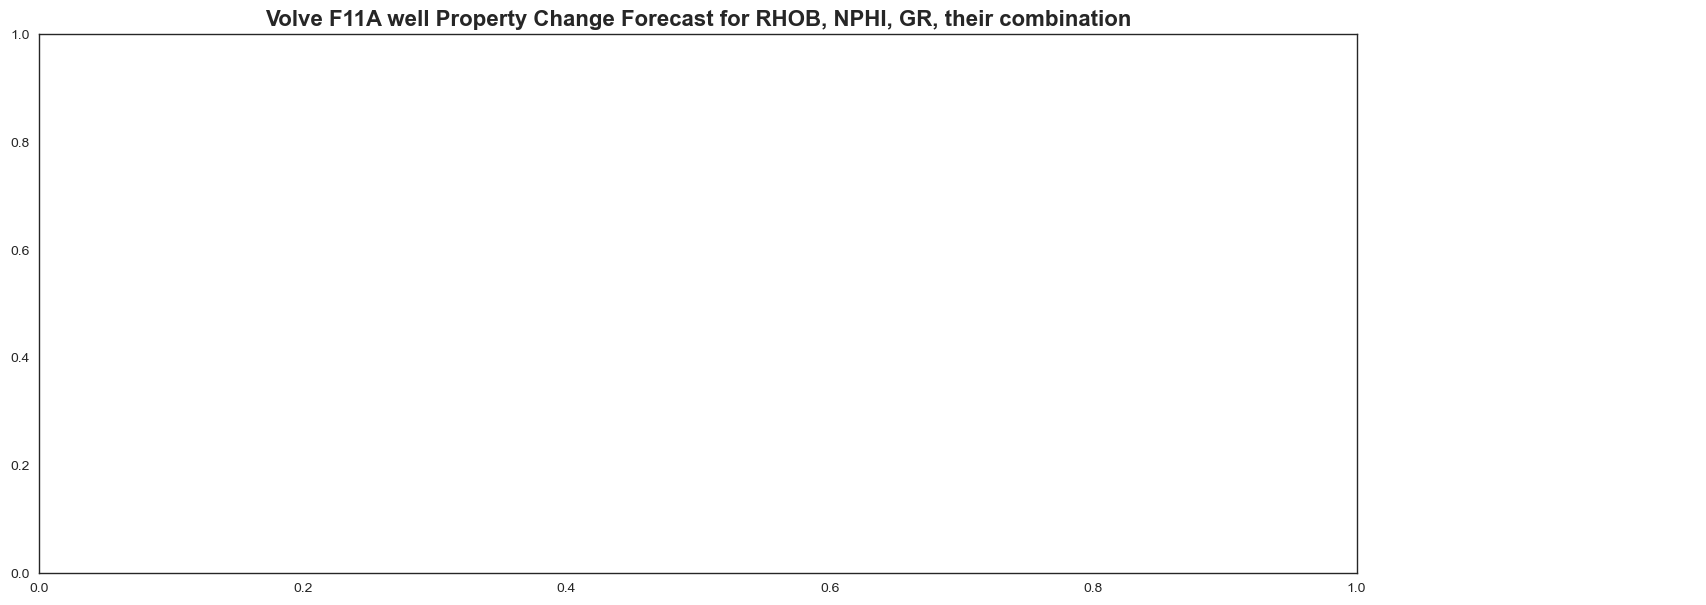

In [211]:
import matplotlib.animation as anim
#import seaborn as sns
#plt.style.use('ggplot')
#sns.set_style('white')
fig, ax = plt.subplots(1, figsize=(17,7))

def volve_anim(i):
    

    #_log_list_nodt = ['NPHI','RHOB','GR']
    #_prob_list_nodt = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']

    #_wellnames_ = ['f1','f1A', 'f1B', 'f11B']
    #_well_df_ = {'f1': df_f1, 'f1A': df_f1A, 'f1B': df_f1B, 'f11A': df_f11A, 'f11B' : df_f11B} # omitted f1C

    _log_list_ = ['NPHI','RHOB','GR']
    #_log_list_ = ['RHOB','GR']
    _prob_list_ = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']
    #_prob_list_ = ['CP_Prob_RHOB','CP_Prob_GR']

    _wellnames_ = ['f1','f1A', 'f1B', 'f11A', 'f11B']
    _well_df_ = {'f1': df_f1, 'f1A': df_f1A, 'f1B': df_f1B, 'f11A': df_f11A, 'f11B' : df_f11B} # omitted f1C

    _logname_extent_min = {'f1': 2620 ,'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
    _logname_extent_max = {'f1': 3590 ,'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }
    _log_extent_min = {0 : 2620, 1 : 3100 , 2: 3100 , 3 : 2600 , 4: 3200 } 
    _log_extent_max = {0: 3600, 1 : 3400 , 2: 4100 , 3 : 3700 , 4: 4550 }
    #peak_height= 0.06 #Probability threshold to qualify as a distinct changepoint

    #operator = 'cosine'
    #thresh = {'CP_Prob_NPHI': 0.9995 ,'CP_Prob_RHOB': 0.99997,'CP_Prob_GR': 0.999}#0.9999


    comparitee = 'f11A'
    peak_height= 0.05 #Probability threshold to qualify as a distinct changepoint

    for well in _wellnames_:
        for _log_choice, _prob_choice in zip(_log_list_, _prob_list_):

            globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                        _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

            print(well+ '_'+ _log_choice + ' complete')
    
    _Tor_wellnames_ = ['f1','f1A', 'f1B', 'f11B']

    index = np.linspace(1, 11000, 101, dtype=int)

    print(index[i])
    
    depth=index[i]
    
    #Tor = []

    # for well in _Tor_wellnames_:
    #     for _prob_, _log_ in zip(_prob_list_,_log_list_):
            
    #         print(_prob_,_log_)
            
    #         Tee = globals()[comparitee+'_'+_log_+'_CPstats']
    #         #print(Tee)
    #         Tor = globals()[well+'_'+_log_+'_CPstats']
    #         current_depth = np.where(Tee[:,0] < depth )[0][-1] # add [:current_depth] to the Tee figure below
    #         globals()[well+'_'+comparitee+'_'+_log_+'_prob_']= prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh, df=_well_df_[well][_logname_extent_min[well]:_logname_extent_max[well]], log=_prob_)
    #         #globals()[well+'_'+comparitee+'_'+_log_+'_prob'] = cp_Comp.prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh[_prob_], df=_well_df_[well], log=_prob_)


    operator = 'cosine'
    thresh = {'CP_Prob_NPHI': 0.995 ,'CP_Prob_RHOB': 0.99997,'CP_Prob_GR': 0.9975}#0.9999#0.9999
    comparitee = 'f11A'

    Tor = []

    #current_depth = np.where(Tee[:,0] < depth )[0][-1]  #### THIS NEEDS TO GO INTO THE FOR LOOP TO WORK
    for well in _Tor_wellnames_:
        for _prob_, _log_ in zip(_prob_list_,_log_list_):
            print(_prob_,_log_)
            Tee = globals()[comparitee+'_'+_log_+'_CPstats']
            Tor = globals()[well+'_'+_log_+'_CPstats']
            current_depth = np.where(Tee[:,0] < depth )[0][-1]
            globals()[well+'_'+comparitee+'_'+_log_+'_prob_'] = cp_Comp.prob_cpCorr(Tee[:current_depth], Tor, operator=operator, thresh=thresh[_prob_], df=_well_df_[well], log=_prob_)


    f11A_probmatrix = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob_, f1A_f11A_NPHI_prob_,  f11B_f11A_NPHI_prob_, f1B_f11A_NPHI_prob_,
                                                      f1_f11A_RHOB_prob_, f1A_f11A_RHOB_prob_,  f11B_f11A_RHOB_prob_, f1B_f11A_RHOB_prob_,
                                                      f1_f11A_GR_prob_, f1A_f11A_GR_prob_, f11B_f11A_GR_prob_, f1B_f11A_GR_prob_, 
                                                     #f1_f11A_PEF_prob, f1A_f11A_PEF_prob, f11B_f11A_PEF_prob, f1B_f11A_PEF_prob,
                                                     )

    f11A_probmatrixNPHI = cp_Comp.combine_vectors_to_matrix_(f1_f11A_NPHI_prob_,
                                                        f1A_f11A_NPHI_prob_,
                                                         f1B_f11A_NPHI_prob_,
                                                         #f1C_f11A_NPHI_prob, 
                                                         f11B_f11A_NPHI_prob_)

    f11A_probmatrixRHOB = cp_Comp.combine_vectors_to_matrix_(f1_f11A_RHOB_prob_,
                                                         f1A_f11A_RHOB_prob_, 
                                                         f1B_f11A_RHOB_prob_,
                                                         #f1C_f11A_RHOB_prob, 
                                                         f11B_f11A_RHOB_prob_)

    f11A_probmatrixGR = cp_Comp.combine_vectors_to_matrix_(f1_f11A_GR_prob_,
                                                       f1A_f11A_GR_prob_,
                                                       f1B_f11A_GR_prob_, 
                                                       #f1C_f11A_GR_prob, 
                                                       f11B_f11A_GR_prob_
                                                       )



    f11A_all_prob = cp_Comp.combine_vectors_to_matrix_(df_f11A['CP_Prob_GR'].to_numpy(),
                                                    df_f11A['CP_Prob_NPHI'].to_numpy(),
                                                    #df_f11A['CP_Prob_PEF'],
                                                    df_f11A['CP_Prob_RHOB'].to_numpy()
                                                    )
    
    #print(well7_probmatrix)
    
    print(depth)
    fig.clear()
    #ax.clear()
    #plt.figure(figsize=(10,15))
    ax.set_ylim((15000,0))
    ax.set_xticks([])
    ax.set_xlim([-3.5, 16])
    ax.set_ylabel('Depth of f11A well log in (cm) (True MD += 26,000)', size =15)
    ax.set_xlabel('Relative Probability, (shifted for clarity with unregularized scale)', size=15)
    #ax.set_xlim(25)
    f11A_top10 = f11A_tops #25400
    #k=0
    for i in f11A_top10:
        ax.axhline(i, alpha=0.7, color='brown', linewidth=1)#, label=f11A_FM[k])
        #print(k)
        #k=k+1
    ax.axhline(0, alpha=0.7, color='brown', linewidth=1, label='Known formation tops')#, label=f11A_FM[k])
    ax.plot(np.sum(f11A_probmatrix, axis=1), np.arange(len(f11A_probmatrix)), linewidth=1, alpha=.4, label='Combined CP Prob', color='k' )
    ax.plot(np.sum(f11A_probmatrixNPHI, axis=1)+13, np.arange(len(f11A_probmatrixNPHI)), linewidth=1, alpha=.6, label = 'NPHI Predicted CP Prob', color ='purple' )
    ax.plot(np.sum(f11A_probmatrixRHOB, axis=1)+9, np.arange(len(f11A_probmatrixRHOB)), linewidth=1, alpha=.6, label = 'RHOB Predicted CP Prob', color='g' )
    #ax.plot(np.sum(f11A_probmatrixPEF, axis=1)+7.6, np.arange(len(f11A_probmatrixPEF)), linewidth=1, alpha=.6, label='PEF Predicted CP Prob')
    ax.plot(np.sum(f11A_probmatrixGR, axis=1)+5, np.arange(len(f11A_probmatrixGR)), linewidth=1, alpha=.66, label = 'GR Predicted Change Point Prob', color ='orange' )
    #ax.plot(f11A_gr*3, np.arange(len(f11A_gr)) , linewidth=1, alpha=.6, label='GR f11A')
    #ax.plot(f11A_pef*3+ +7, np.arange(len(f11A_pef)) , linewidth=1, alpha=.6, label='GR f11A')
    #ax.plot(f11A_nphi*3, np.arange(len(f11A_nphi)) , linewidth=1, alpha=.6, label='GR f11A')
    #ax.plot(f11A_rhob*3, np.arange(len(f11A_rhob)) , linewidth=1, alpha=.6, label='GR f11A')
    
    ######### PLOTTING DRILLING TRACE #########
    ax.plot(np.sum(f11A_all_prob[:depth], axis=1)-3, np.arange(len(f11A_all_prob[:depth])), linewidth=1, alpha=0.6, label='f11A Measured Prob', color='b')
    f11A_GR = (cp_Comp.normalize_array(wtool.replace_nans(df_f11A['GR'].to_numpy(), method='global_average'), 0.1 ,0.1))
    f11A_y = np.arange(len(f11A_GR[:depth]))
    ax.plot(f11A_GR[:depth]-1.5, f11A_y, linewidth=1, color='red', alpha=0.6, label='f11A GR log')
    #maxx = len(df_f11A)

    plt.title('Volve F11A well Property Change Forecast for RHOB, NPHI, GR, their combination', fontsize=16, fontweight='bold')
    #f11A_top10
    #cmap = plt.colormaps('turbo')


    #fig.legend(loc='center right', markerscale=2, frameon=False, bbox_to_anchor=(1.1,.6), fontsize=13)
    leg=fig.legend(bbox_to_anchor=(1.1,.7), fontsize=13, frameon=False, markerscale=10, borderaxespad=0.)

    for l in leg.get_lines():
        l.set_alpha(1)
        #l.set_marker('.')
    #fig.legend(loc='center right', frameon=False, bbox_to_anchor=(1.1,.6), fontsize=13)
    #fig.legend(loc='center right', frameon=False, bbox_to_anchor=(1.1,.6), prop={'size' :13 ,'weight':'bold'})
    #fig.canvas.draw()
    return fig, 


#volve_anim(100)
volve_anim = anim.FuncAnimation(fig, volve_anim,
    frames = 100, interval = 100, blit = True)

# = anim.ArtistAnimation(fig, plot_all, frames=400, interval = 80, blit=True)
volve_anim.save('..//../reports/figures/drilling_volve_anim.mp4', writer = 'ffmpeg', fps = 8)

In [38]:
df_grab_1 = pd.DataFrame()
well1 = pd.DataFrame(np.array([wellpath1[:,0], wellpath1[:,1], wellpath1[:,2], welldata1[1], welldata1[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well2 = pd.DataFrame(np.array([wellpath2[:,0], wellpath2[:,1], wellpath2[:,2], welldata2[1], welldata2[3]],dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well3 = pd.DataFrame(np.array([wellpath3[:,0], wellpath3[:,1], wellpath3[:,2], welldata3[1], welldata3[3]],dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well4 = pd.DataFrame(np.array([wellpath4[:,0], wellpath4[:,1], wellpath4[:,2], welldata4[1], welldata4[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well5 = pd.DataFrame(np.array([wellpathRand1[:,0], wellpathRand1[:,1], wellpathRand1[:,2], welldataRand1[1], welldataRand1[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])
well6 = pd.DataFrame(np.array([wellpathRand2[:,0], wellpathRand2[:,1], wellpathRand2[:,2], welldataRand2[1], welldataRand2[3]], dtype='float64').T, columns=['X', 'Y', 'MD','PHI','RHO'])


In [459]:
# #syn_graben_anim(19)
# #%matplotlib notebook
# grab_anim = anim.FuncAnimation(fig, syn_graben_anim,
#     frames = 49, interval = 100, blit = True)

# # = anim.ArtistAnimation(fig, plot_all, frames=400, interval = 80, blit=True)
# grab_anim.save('syn_grab_.mp4', writer = 'ffmpeg', fps = 8)
# #plt.plot(OBSERwelldata[0][:400], OBSERwellpath[:400,2], alpha=0.6)

In [ ]:

import matplotlib.animation as anim
import seaborn as sns
#plt.style.use('ggplot')
sns.set_style('white')
fig, ax = plt.subplots(1, figsize=(17,7))

def volve_anim(i):


    _logname_extent_min = {'f1': 2620 ,'f1A' : 2620, 'f1B' : 3100 , 'f1C': 3100 , 'f11A' : 2600 , 'f11B': 3200 }
    _logname_extent_max = {'f1': 3590 ,'f1A' : 3600, 'f1B' : 3400 , 'f1C': 4100 , 'f11A' : 3700 , 'f11B': 4550 }

    _log_list_ = ['NPHI','RHOB','GR']
    _prob_list_ = ['CP_Prob_NPHI','CP_Prob_RHOB','CP_Prob_GR']
    #_wellnames_ = ['f1B']
    _wellnames_ = ['f1','f1A', 'f1B', 'f11A', 'f11B'] #omitted F1C
    _well_df_ = {'f1': df_f1, 'f1A': df_f1A, 'f1B': df_f1B,'f11A': df_f11A, 'f11B' : df_f11B} #omitted f1C

    peak_height= 0.09 #Probability threshold to qualify as a distinct changepoint

    operator = 'cosine'
    thresh = {'CP_Prob_NPHI': 0.9 ,'CP_Prob_RHOB': 0.9,'CP_Prob_GR': 0.9}#0.9999

    comparitee = 'f11A'


    for well in _wellnames_:
        for _log_choice, _prob_choice in zip(_log_list_, _prob_list_):

            globals()[well+'_'+_log_choice+'_CPstats'] = cp_Comp.changepoint_stat(_well_df_[well][_log_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), 
                                                        _well_df_[well][_prob_choice][_logname_extent_min[well]:_logname_extent_max[well]].to_numpy(), height=peak_height, stat_margin=0)

            print(well+ '_'+ _log_choice + ' complete')
    
    _Tor_wellnames_ = ['f1','f1A', 'f1B', 'f11B']

    idx = np.linspace(1, 11000, 101, dtype=int)

    print(idx[i])
    
    depth=idx[i]

    for well in _Tor_wellnames_:
        for _prob_, _log_ in zip(_prob_list_,_log_list_):
            print(_prob_,_log_)
            Tee = globals()[comparitee+'_'+_log_+'_CPstats'] 
            Tor = globals()[well+'_'+_log_+'_CPstats']
        
            globals()[well+'_'+comparitee+'_'+_log_+'_prob_'] = prob_cpCorr(Tee, Tor, operator=operator, thresh=thresh[_prob_], df=_well_df_[well], log=_prob_)
            #globals()[well+'_'+comparitee+'_'+_log_+'_prob_']             

